(more or less) Copying code from https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import re
import numpy as np
import spacy
import gensim
from gensim import corpora

#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
reviews = pd.read_csv("RMP-data.csv").loc[:, ["professor_name", "comments", "student_star"]]
reviews.dropna(inplace=True)
reviews.head()

,professor_name,comments,student_star
0,Leslie Looney,"This class is hard, but its a two-in-one gen-ed knockout, and the content is very stimulating. Unlike most classes, you have to actually participate to pass. Sections are easy and offer extra cred...",5.0
1,Leslie Looney,Definitely going to choose Prof. Looney\'s class again! Interesting class and easy A. You can bring notes to exams so you don\'t need to remember a lot. Lots of bonus points available and the obse...,5.0
2,Leslie Looney,I overall enjoyed this class because the assignments were straightforward and interesting. I just didn\'t enjoy the video project because I felt like no one in my group cared enough to help.,4.0
3,Leslie Looney,"Yes, it\'s possible to get an A but you\'ll definitely have to work for it. The content is pretty interesting, but you have tog get super organized in this class. You\'ll have multiple things due ...",5.0
4,Leslie Looney,"Professor Looney has great knowledge in Astronomy, while he can explain them in a super easy way in an elementary class. He taught this class with great passion and great illustration. This class ...",5.0


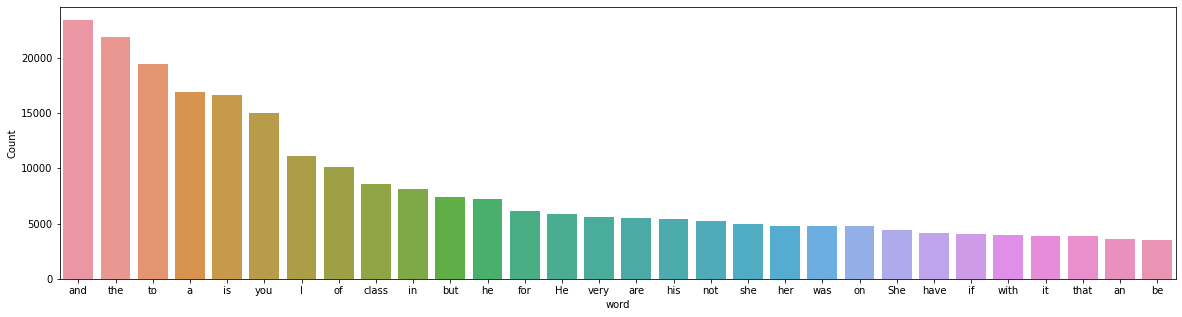

In [3]:
# function to find most frequent terms
def freq_words(x, terms=30):
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})
    
    # selecting 20 most frequent terms
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_words(reviews["comments"])

In [4]:
# remove unwanted chars, stopwords, and short words from comments
reviews["comments"] = reviews["comments"].str.replace("[^a-zA-Z#]", " ")

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stopwords.words("english")])
    return rev_new

reviews["comments"] = reviews["comments"].apply(lambda x: " ".join([w for w in x.split() if len(w) > 2]))

#df = [r.lower() for r in reviews["comments"]]
#df = [remove_stopwords(r) for r in df]

df = [remove_stopwords(r.split()) for r in reviews["comments"]]
df = [r.lower() for r in df]

C:\Users\ethan\AppData\Local\Temp\ipykernel_32128\1637318064.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews["comments"] = reviews["comments"].str.replace("[^a-zA-Z#]", " ")


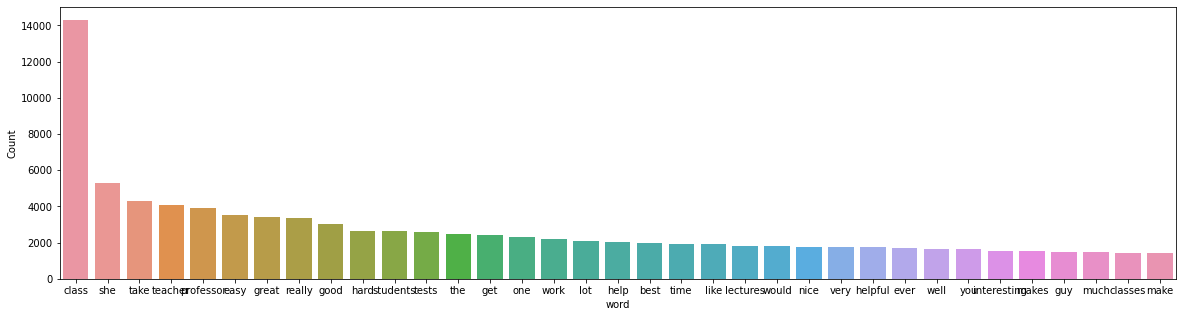

In [5]:
freq_words(df, 35)

In [6]:
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

def lemmatization(texts, tags=["NOUN", "ADJ"]):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [7]:
tokenized_reviews = pd.Series(df).apply(lambda x: x.split())
print(tokenized_reviews[1])

['definitely', 'going', 'choose', 'prof', 'looney', 'class', 'interesting', 'class', 'easy', 'you', 'bring', 'notes', 'exams', 'need', 'remember', 'lot', 'lots', 'bonus', 'points', 'available', 'observatory', 'sessions', 'awesome']


In [8]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['looney', 'class', 'interesting', 'class', 'note', 'exam', 'lot', 'lot', 'bonus', 'point', 'available', 'observatory', 'session', 'awesome']


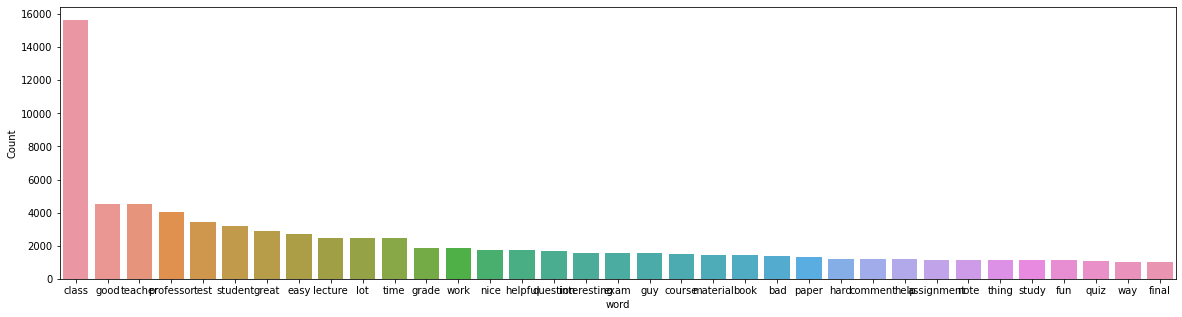

In [9]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(" ".join(reviews_2[i]))

reviews["reviews"] = reviews_3

freq_words(reviews["reviews"], 35)

In [10]:
# Building LDA model
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [11]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7,           # specify desired # of topics here
                random_state=0, chunksize=1000, passes=50)

In [12]:
lda_model.print_topics()

[(0,
  '0.110*"class" + 0.029*"easy" + 0.026*"grade" + 0.024*"paper" + 0.021*"lot" + 0.021*"final" + 0.017*"time" + 0.017*"test" + 0.017*"assignment" + 0.017*"quiz"'),
 (1,
  '0.093*"class" + 0.055*"professor" + 0.052*"good" + 0.045*"great" + 0.036*"interesting" + 0.030*"teacher" + 0.025*"lot" + 0.023*"fun" + 0.020*"student" + 0.017*"subject"'),
 (2,
  '0.045*"class" + 0.023*"grader" + 0.022*"nice" + 0.022*"course" + 0.021*"time" + 0.020*"tough" + 0.017*"guy" + 0.016*"grading" + 0.016*"assignment" + 0.016*"fair"'),
 (3,
  '0.089*"teacher" + 0.071*"class" + 0.044*"good" + 0.039*"student" + 0.034*"professor" + 0.031*"great" + 0.027*"help" + 0.023*"bad" + 0.020*"awesome" + 0.020*"work"'),
 (4,
  '0.083*"class" + 0.062*"test" + 0.040*"question" + 0.039*"lecture" + 0.028*"note" + 0.027*"book" + 0.027*"study" + 0.026*"exam" + 0.019*"easy" + 0.015*"time"'),
 (5,
  '0.139*"comment" + 0.065*"hour" + 0.037*"office" + 0.023*"impossible" + 0.017*"method" + 0.012*"unorganized" + 0.012*"luck" + 0.01

In [13]:
# Visualize Topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.158579  0.110032       1        1  20.381697
0     -0.155906  0.097918       2        1  19.983972
1     -0.120782 -0.097258       3        1  18.514869
3     -0.103928 -0.078456       4        1  17.273231
2     -0.084339  0.031869       5        1  12.319542
6      0.243007 -0.290112       6        1   6.924891
5      0.380527  0.226005       7        1   4.601798, topic_info=         Term         Freq        Total Category  logprob  loglift
47    teacher  4214.000000  4214.000000  Default  30.0000  30.0000
311   comment  1282.000000  1282.000000  Default  29.0000  29.0000
111      test  3211.000000  3211.000000  Default  28.0000  28.0000
41      great  2779.000000  2779.000000  Default  27.0000  27.0000
276  question  1642.000000  1642.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
57    science   100.088881   189.319986   Topic7  -4.5257   2.4413
563      rude   106.667894   277.220482   Topic7  -4.4620   2.1236
409  terrible    88.728626   222.897600   Topic7  -4.6462   2.1576
351      date    57.636820    98.151852   Topic7  -5.0776   2.5464
392     email    70.798703   269.786172   Topic7  -4.8719   1.7409

[406 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
886       3  0.980823   ability
556       7  0.989274  absolute
1880      4  0.985614       act
438       3  0.987602  activity
1537      1  0.991851    actual
...     ...       ...       ...
304       2  0.038476      year
304       3  0.219540      year
304       4  0.457187      year
304       5  0.282913      year
1673      1  0.983986     young

[514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3, 7, 6])